In [1]:
import importlib
import pandas as pd
import analysis_functions as af
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
import os
import pickle
from matplotlib.animation import FuncAnimation

In [2]:
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\v1ctldata_full.pkl")
with open(desktop_path, 'rb') as f:
    behv_data = pickle.load(f)

In [ ]:
# jfdksla

In [3]:
# downsample from 1000fps to 10fps

for ani in behv_data:
    behv_data[ani]['grating_indices']['gr_1'] = np.array(behv_data[ani]['grating_indices']['gr_1'])//100
    behv_data[ani]['grating_indices']['gr_2'] = np.array(behv_data[ani]['grating_indices']['gr_2'])//100
    behv_data[ani]['trial_start_indices'] = np.array(behv_data[ani]['trial_start_indices'])//100
    behv_data[ani]['reward_indices'] = np.array(behv_data[ani]['reward_indices'])//100

    # downsample the position data by calculating the average every 100 frames
    num_groups = behv_data[ani]['position'].shape[0] // 100
    behv_data[ani]['position'] = behv_data[ani]['position'].reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk

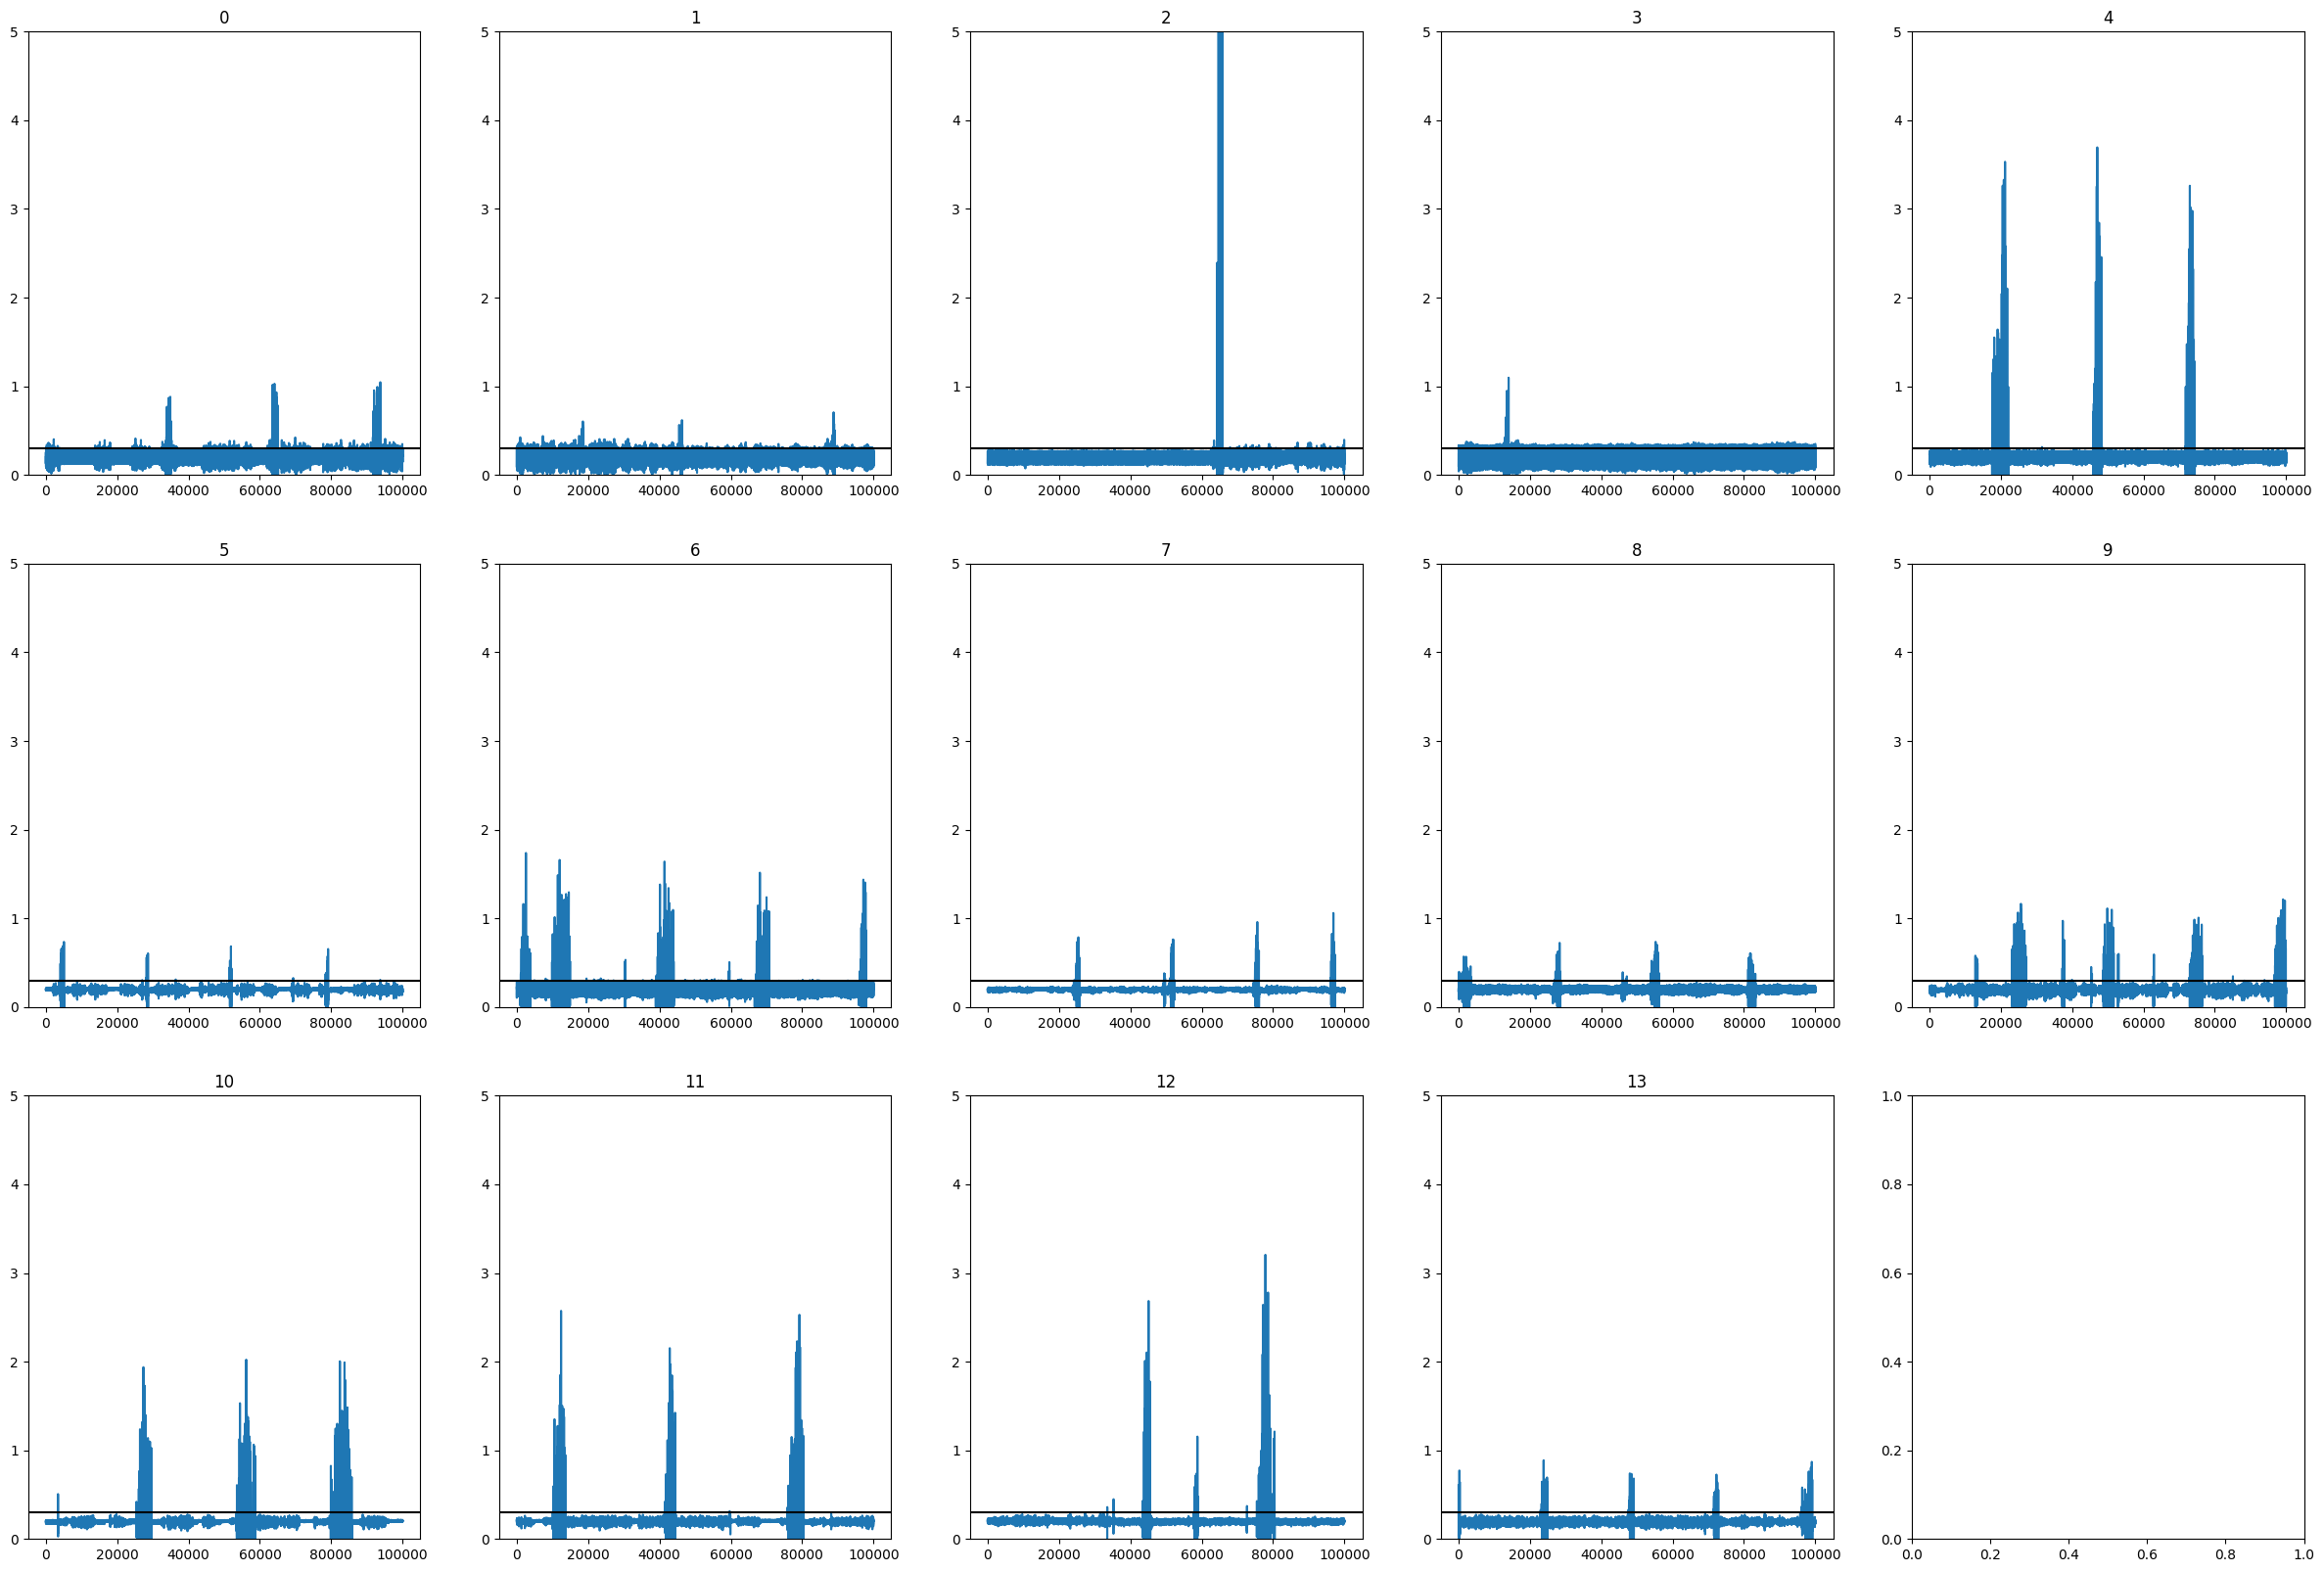

In [85]:
from scipy.ndimage import gaussian_filter1d

sample_rate = 1000
max_lick_rate = 10
lick_onsets = {}

fig, axes = plt.subplots(3, 5, figsize=(30, 20))
axes = axes.flatten() 

for ani in behv_data:
    lick_onsets[ani] = []
    lick_signal = gaussian_filter1d(behv_data[ani]['lick'], sigma= 1, axis=0)
    # threshold = np.percentile(lick_signal,99,axis=0) 
    threshold = 0.3   # fixed threshold looks better--- some animals has quite low piezo signal so 99% is not high enough for them but already too high for other animals 

    axes[ani].plot(lick_signal[1500000:1600000])
    axes[ani].axhline(threshold, color='k')
    axes[ani].set_ylim([0,5])
    axes[ani].set_title(f'{ani}')
    
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(lick_signal, a_min=None, a_max=max_valid)
    above = lick_signal > threshold
    min_interval = sample_rate/max_lick_rate #  refractory period
    crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1  
    if len(crossings) > 0:
        lick_onsets[ani] = [crossings[0]]
        for idx in crossings[1:]:
            if idx - lick_onsets[ani][-1] >= min_interval:
                lick_onsets[ani].append(idx)
        lick_onsets[ani] = np.array(lick_onsets[ani])
    else:
        lick_onsets[ani] = np.array([])

In [86]:
# calculate the lick_record and lick_rate

lick_record = {}
for ani in behv_data:
    lick_record[ani] = np.zeros(int(behv_data[ani]['lick'].shape[0]//min_interval))
    down_sampled_lick_onsets = lick_onsets[ani]//100
    for num in down_sampled_lick_onsets:
        lick_record[ani][num] = 1

lick_rate = {}
frame_rate = 10 
window_frames = frame_rate 
for ani in behv_data:
    lick_series = pd.Series(lick_record[ani])
    # Rolling sum over 1s window
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()
    # Convert to licks/sec (since window is 1 sec, just divide by 1)
    lick_rate[ani] = lick_count.values

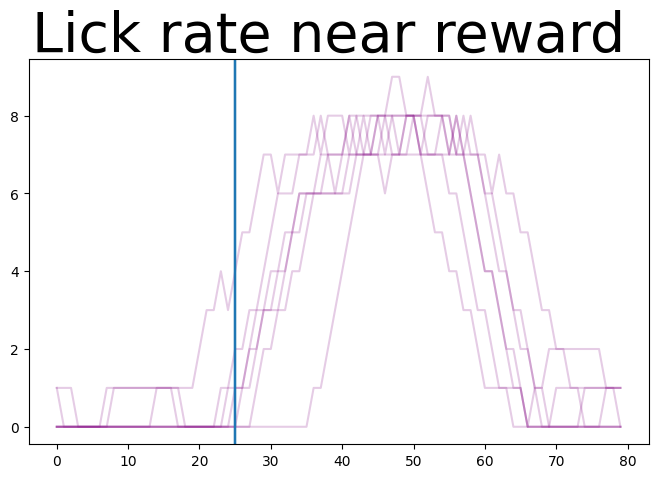

In [87]:
data = behv_data

unexp_rw = {}
exp_rw = {}
for ani in data:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data[ani]['reward_indices'][trial]-25,data[ani]['reward_indices'][trial]+55)) 
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data[ani]['reward_indices'][trial-1]-25,data[ani]['reward_indices'][trial-1]+55))

ani = 9
fig, ax = plt.subplots(figsize=(8, 5)) 
fig.suptitle("Lick rate near reward", fontsize=40)
t_frames = 80
for i in range(7):
    plt.plot(lick_rate[ani][exp_rw[ani][i]], color='purple', alpha=0.2, label='Unexpected X')
    ax.axvline([25])
# af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][unexp_rw[ani][0]], color='purple', alpha=0.2, label='Unexpected X')
# af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][unexp_rw[ani][]], color='purple', alpha=0.2, style='dash', label='Expected X')
# af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][exp_rw[ani][:7]], color='blue', alpha=0.2, label= 'Expected B')
# ax.axvline([25], color='black')
# ax.set_ylabel('Lick rate')
# ax.set_xlabel('Frames')
# ax.set_title(f'{ani}')
# ax.legend()

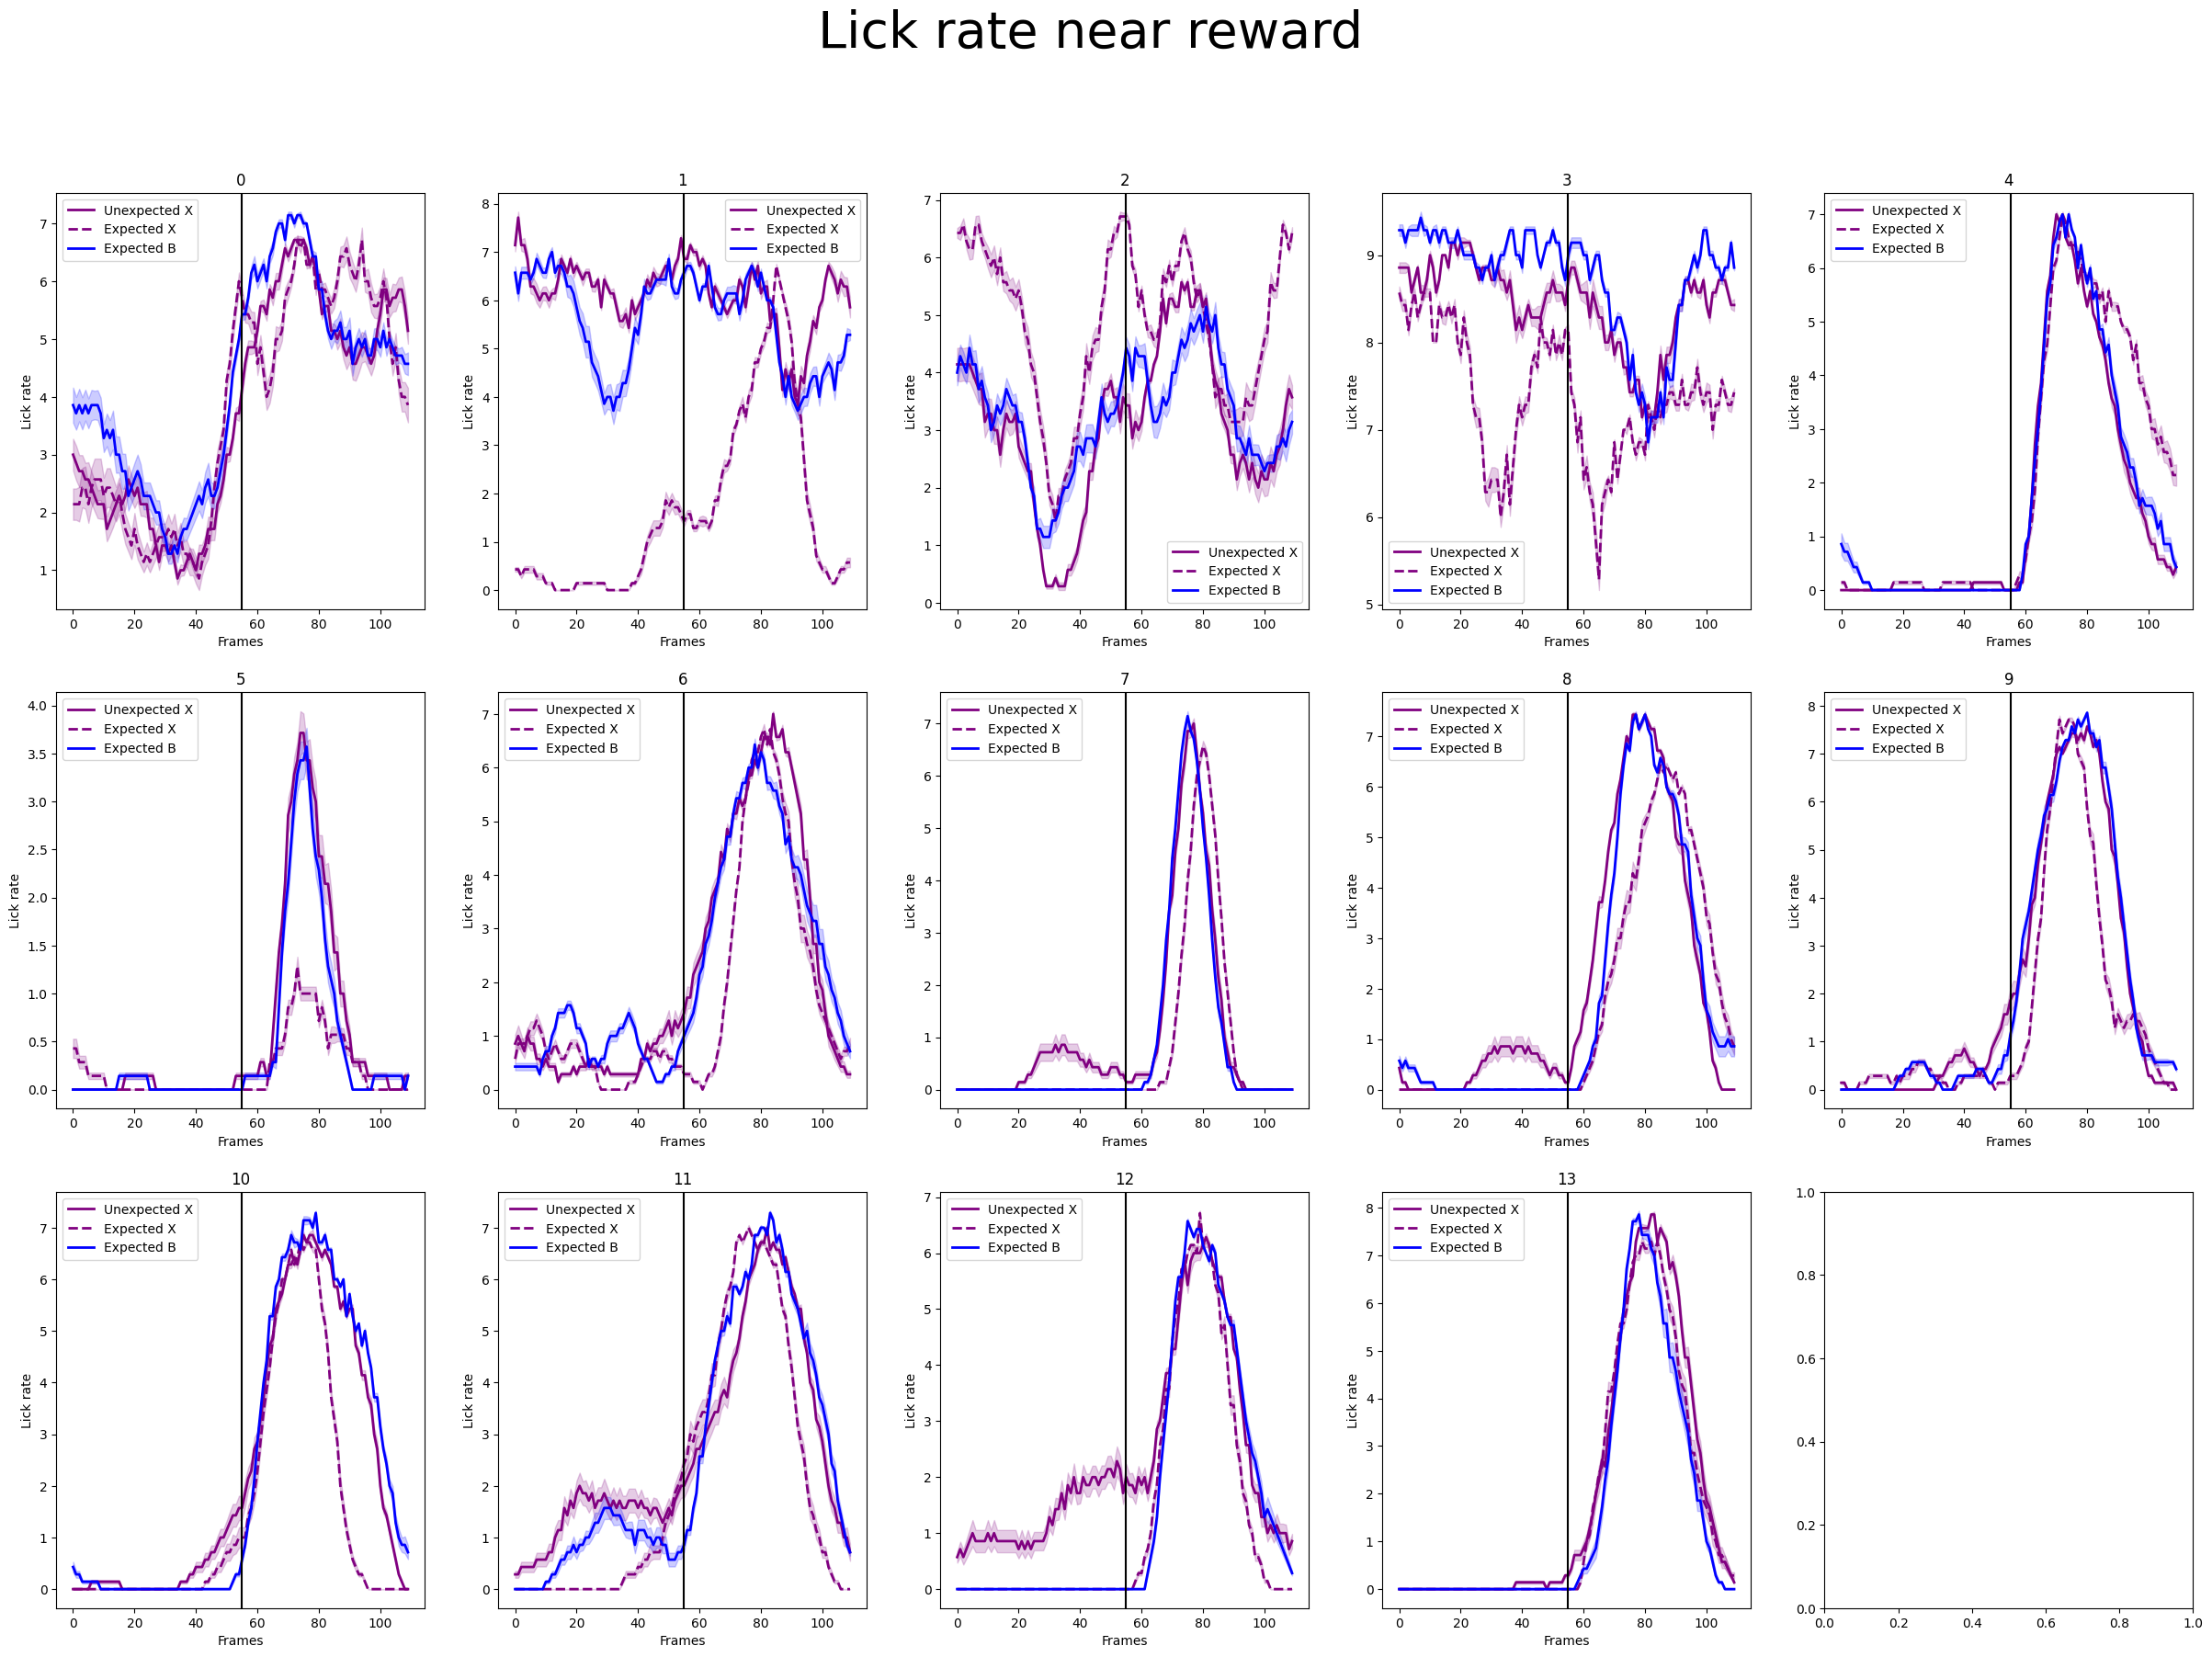

In [88]:
# Lick Near Reward for each animal

data = behv_data

unexp_rw = {}
exp_rw = {}
for ani in data:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data[ani]['reward_indices'][trial]-55,data[ani]['reward_indices'][trial]+55)) 
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data[ani]['reward_indices'][trial-1]-55,data[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(3, 5, figsize=(30, 20)) 
fig.suptitle("Lick rate near reward", fontsize=40)
t_frames = 110
for i, ani in enumerate(behv_data):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][unexp_rw[ani][:7]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][unexp_rw[ani][20:27]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][exp_rw[ani][:7]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([55], color='black')
    ax.set_ylabel('Lick rate')
    ax.set_xlabel('Frames')
    ax.set_title(f'{ani}')
    ax.legend()

# anticipatory licking: [1,3,6,9,10,11,12]      # any unbiased way? 

In [ ]:
for ani in data:
    print(data[ani]['reward_indices'] - data[ani]['grating_indices']['gr_2'][:len(data[ani]['reward_indices'])]) 
    # print(min(data[ani]['reward_indices'] - data[ani]['grating_indices']['gr_2'][:len(data[ani]['reward_indices'])]))

[ 38  34  35  38  41  37  37  42  38  50  37  35  44 136  35  35  37  34
  36  39  36  38  36  36  37  40  62  44  74  46  89  69  42  38  47  72
  75  67  79  51  35  50  67  43  83  54  54  35  40  80  70  70  57  35
 122 106  39  53  40  51 191  96  42  81  48  48 287  36  65  39  80  76
  68  91  68  45  68  37  51  55  64  80  43  54  72  62  77  43  52  67
  59  93  37  38  36  81  90  35  38  38  76  81  40  35  45  42  87 395
  39  53  99  92  55  43  35 146  44  37  42  38  67  84  86  85  45  56
  46  82  78  81  65  51  74  71  52  68 147  86  81  53 105  37  74  63
  61  96  52  37  94  40  44 191  40 132 102  39  54 116  78  84  71  95
  54  39  43 195  61  91  46  96 121  58 103 138  78 133  61  68  38  36
 128  76  56  61  79 101  38  82 117 153  56  58  41  39  44  85  46 171
 192  95 145  35  51  56  38  45  58  91  43  38  58 144  37  39  63  43
  52  37 180  53  45  49  68  37  37  60  47 108  62]
[ 39  34  42  40  40  35  38  96  44  38  40  39  46  46  38  40  41  

In [89]:
unexp_rw = {}
exp_rw = {}
for ani in data:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data[ani]['reward_indices'][trial]-35,data[ani]['reward_indices'][trial]+55)) 
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data[ani]['reward_indices'][trial-1]-35,data[ani]['reward_indices'][trial-1]+55))

# ani = 1
# print(lick_record[ani][exp_rw[ani][:7]][:,5:55])
# print(lick_record[ani][exp_rw[ani][20:27]])
# print(lick_record[ani][exp_rw[ani][20:27]])

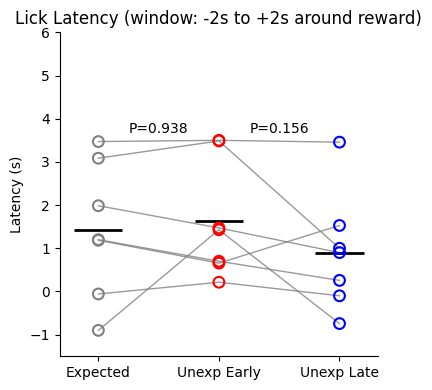

In [91]:
# Lick latency three points plot  --- 3 seconds prior to reward

from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

results = []
anticipatory_lick_animals = [1,3,6,9,10,11,12]   
for ani in anticipatory_lick_animals:
    arr = lick_record[ani][exp_rw[ani][:7]][:,0:55]  # the response window: 3 seconds before the reward --- 2 seconds after the reward
    first_lick_exp_B = []
    for row in arr:
        ones = np.where(row == 1)[0]   # np.where row == 1
        if len(ones) > 0:
            first_lick_exp_B.append(35 - ones[0])   # the first lick range from 20 frames (before reward presentation) to -20 frames(after ...) e.g. if animal lick very early then store as 20 frames
        else:
            first_lick_exp_B.append(-20)
    arr = lick_record[ani][unexp_rw[ani][:7]][:,0:55]
    first_lick_unexp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_unexp_X.append(35 - ones[0]) 
        else:
            first_lick_unexp_X.append(-20)
    arr = lick_record[ani][unexp_rw[ani][20:27]][:,0:55]
    first_lick_exp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]
        if len(ones) > 0:
            first_lick_exp_X.append(35 - ones[0]) 
        else:
            first_lick_exp_X.append(-20)
    results.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
results = np.array(results)/10  # convert frames to seconds

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(figsize=(4,4))
for i, xpos in enumerate(x_positions):
    ax.scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax.plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax.hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    # print(label, "Wilcoxon p =", p)
ax.set_ylim([-1.5,6])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax.text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax.text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax.set_title('Lick Latency (window: -2s to +2s around reward)')
ax.set_ylabel('Latency (s)')
plt.tight_layout()
plt.show()



# Tricky.,,, cuz even use very early window latency is still below zero

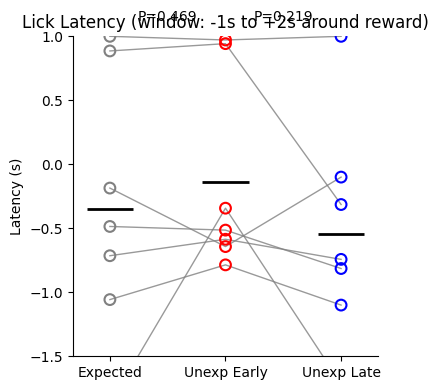

In [92]:
# Lick latency three points plot    ----- 1 seconds prior to reward

from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

results = []
anticipatory_lick_animals = [1,3,6,9,10,11,12]   
for ani in anticipatory_lick_animals:
    arr = lick_record[ani][exp_rw[ani][:7]][:,15:45]  # the response window: 1 seconds before the reward --- 2 seconds after the reward
    first_lick_exp_B = []
    for row in arr:
        ones = np.where(row == 1)[0]   # np.where row == 1
        if len(ones) > 0:
            first_lick_exp_B.append(10 - ones[0])   # the first lick range from 10 frames (before reward presentation) to -20 frames(after ...) e.g. if animal lick very early then store as 10 frames
        else:
            first_lick_exp_B.append(-20)
    arr = lick_record[ani][unexp_rw[ani][:7]][:,15:45]
    first_lick_unexp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_unexp_X.append(10 - ones[0]) 
        else:
            first_lick_unexp_X.append(-20)
    arr = lick_record[ani][unexp_rw[ani][20:27]][:,15:45]
    first_lick_exp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]
        if len(ones) > 0:
            first_lick_exp_X.append(10 - ones[0]) 
        else:
            first_lick_exp_X.append(-20)
    results.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
results = np.array(results)/10  # convert frames to seconds

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(figsize=(4,4))
for i, xpos in enumerate(x_positions):
    ax.scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax.plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax.hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    # print(label, "Wilcoxon p =", p)
ax.set_ylim([-1.5,1])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax.text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax.text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax.set_title('Lick Latency (window: -1s to +2s around reward)')
ax.set_ylabel('Latency (s)')
plt.tight_layout()
plt.show()

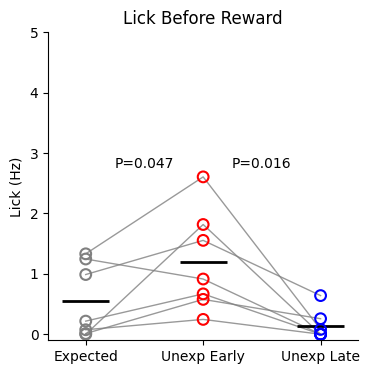

In [301]:
# Lick rate 1 seconds prior to the reward three points plot

from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
anticipatory_lick_animals = [1,3,6,9,10,11,12]  
for ani in anticipatory_lick_animals:
    results.append([np.mean(np.mean(lick_rate[ani][exp_rw[ani][:7]][:,:25], axis = 0),axis = 0), np.mean(np.mean(lick_rate[ani][unexp_rw[ani][:7]][:,:25], axis = 0),axis = 0), np.mean(np.mean(lick_rate[ani][unexp_rw[ani][20:27]][:,:25], axis = 0),axis = 0)])
results = np.array(results)   # shape = (n_animals, 3)

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(figsize=(4,4))
for i, xpos in enumerate(x_positions):
    ax.scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax.plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax.hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines

# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)

ax.set_ylim([-0.1,5])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax.text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')

i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax.text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax.set_title('Lick Before Reward')
ax.set_ylabel('Lick (Hz)')

plt.tight_layout
plt.show()

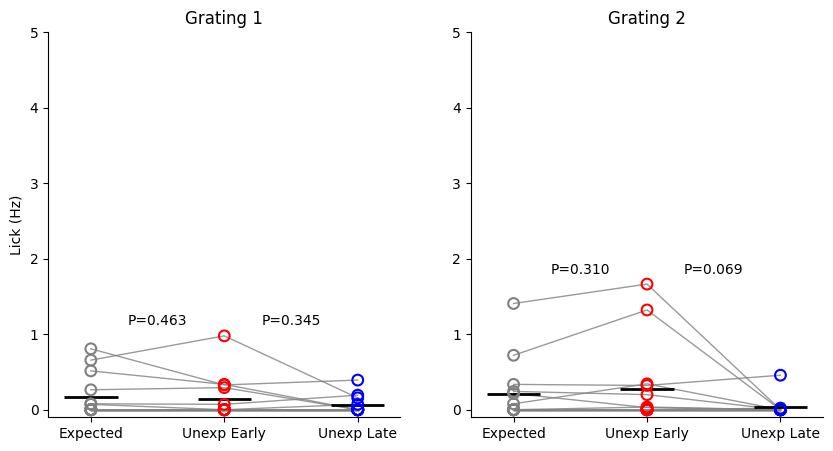

In [303]:
# Lick rate near the two gratings three points plot

unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial]-25,data[ani]['grating_indices']['gr_1'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial-1]-25,data[ani]['grating_indices']['gr_1'][trial-1]+55))

results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in data:
    results.append([np.mean(np.mean(lick_rate[ani][exp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(lick_rate[ani][unexp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(lick_rate[ani][unexp_grat[ani][20:27]][:,25:45],axis=0),axis=0)])
results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, xpos in enumerate(x_positions):
    ax[0].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[0].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[0].set_ylim([-0.1,5])
ax[0].set_xticks([1, 2, 3])
ax[0].set_ylabel('Lick (Hz)')
ax[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    # print(label, "Wilcoxon p =", p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[0].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[0].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[0].set_title('Grating 1')


unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial]-25,data[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial-1]-25,data[ani]['grating_indices']['gr_2'][trial-1]+55))
results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in data:
    results.append([np.mean(np.mean(lick_rate[ani][exp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(lick_rate[ani][unexp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(lick_rate[ani][unexp_grat[ani][20:27]][:,25:45],axis=0),axis=0)])
results = np.array(results)   # shape = (n_animals, 3)

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    ax[1].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[1].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[1].set_ylim([-0.1,5])
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    # print(label, "Wilcoxon p =", p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[1].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[1].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[1].set_title('Grating 2')

# fig.suptitle('Lick after gratings')
plt.tight_layout
plt.show()

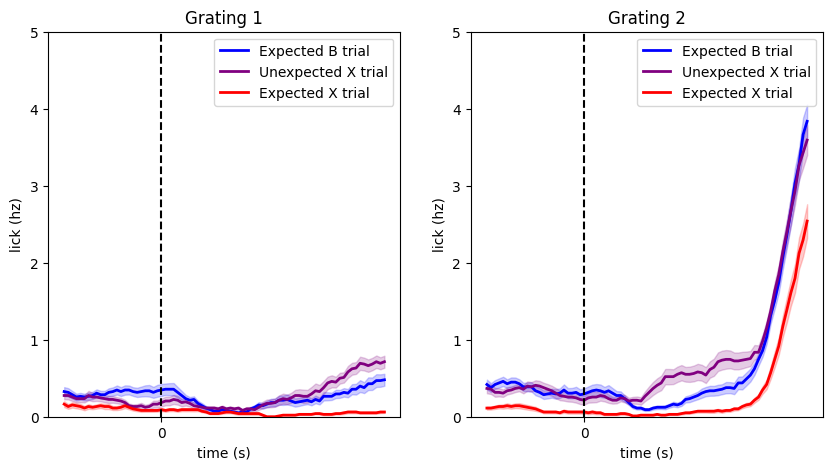

In [93]:
# Lick rate at gratings averaged over all animals

data = behv_data

fig,axes = plt.subplots(1,2,figsize=(10,5))

unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial]-25,data[ani]['grating_indices']['gr_1'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial-1]-25,data[ani]['grating_indices']['gr_1'][trial-1]+55))

t_frames = 80
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([lick_rate[ani][exp_grat[ani][:7]] for ani in data]), axis = 1),color='blue', alpha=0.2, ylim = 0,  label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([lick_rate[ani][unexp_grat[ani][:7]] for ani in data]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([lick_rate[ani][unexp_grat[ani][21:28]] for ani in data]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[0].set_title('Grating 1')
axes[0].axvline(x=24, color='k', linestyle='--')
plt.setp(axes,ylim=[0,5], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='lick (hz)')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial]-25,data[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial-1]-25,data[ani]['grating_indices']['gr_2'][trial-1]+55))

t_frames = 80
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([lick_rate[ani][exp_grat[ani][:7]] for ani in data]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([lick_rate[ani][unexp_grat[ani][:7]] for ani in data]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([lick_rate[ani][unexp_grat[ani][21:28]] for ani in data]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[1].set_title('Grating 2')
axes[1].axvline(x=24, color='k', linestyle='--')
plt.setp(axes,ylim=[0,5], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='lick (hz)')
axes[1].legend()

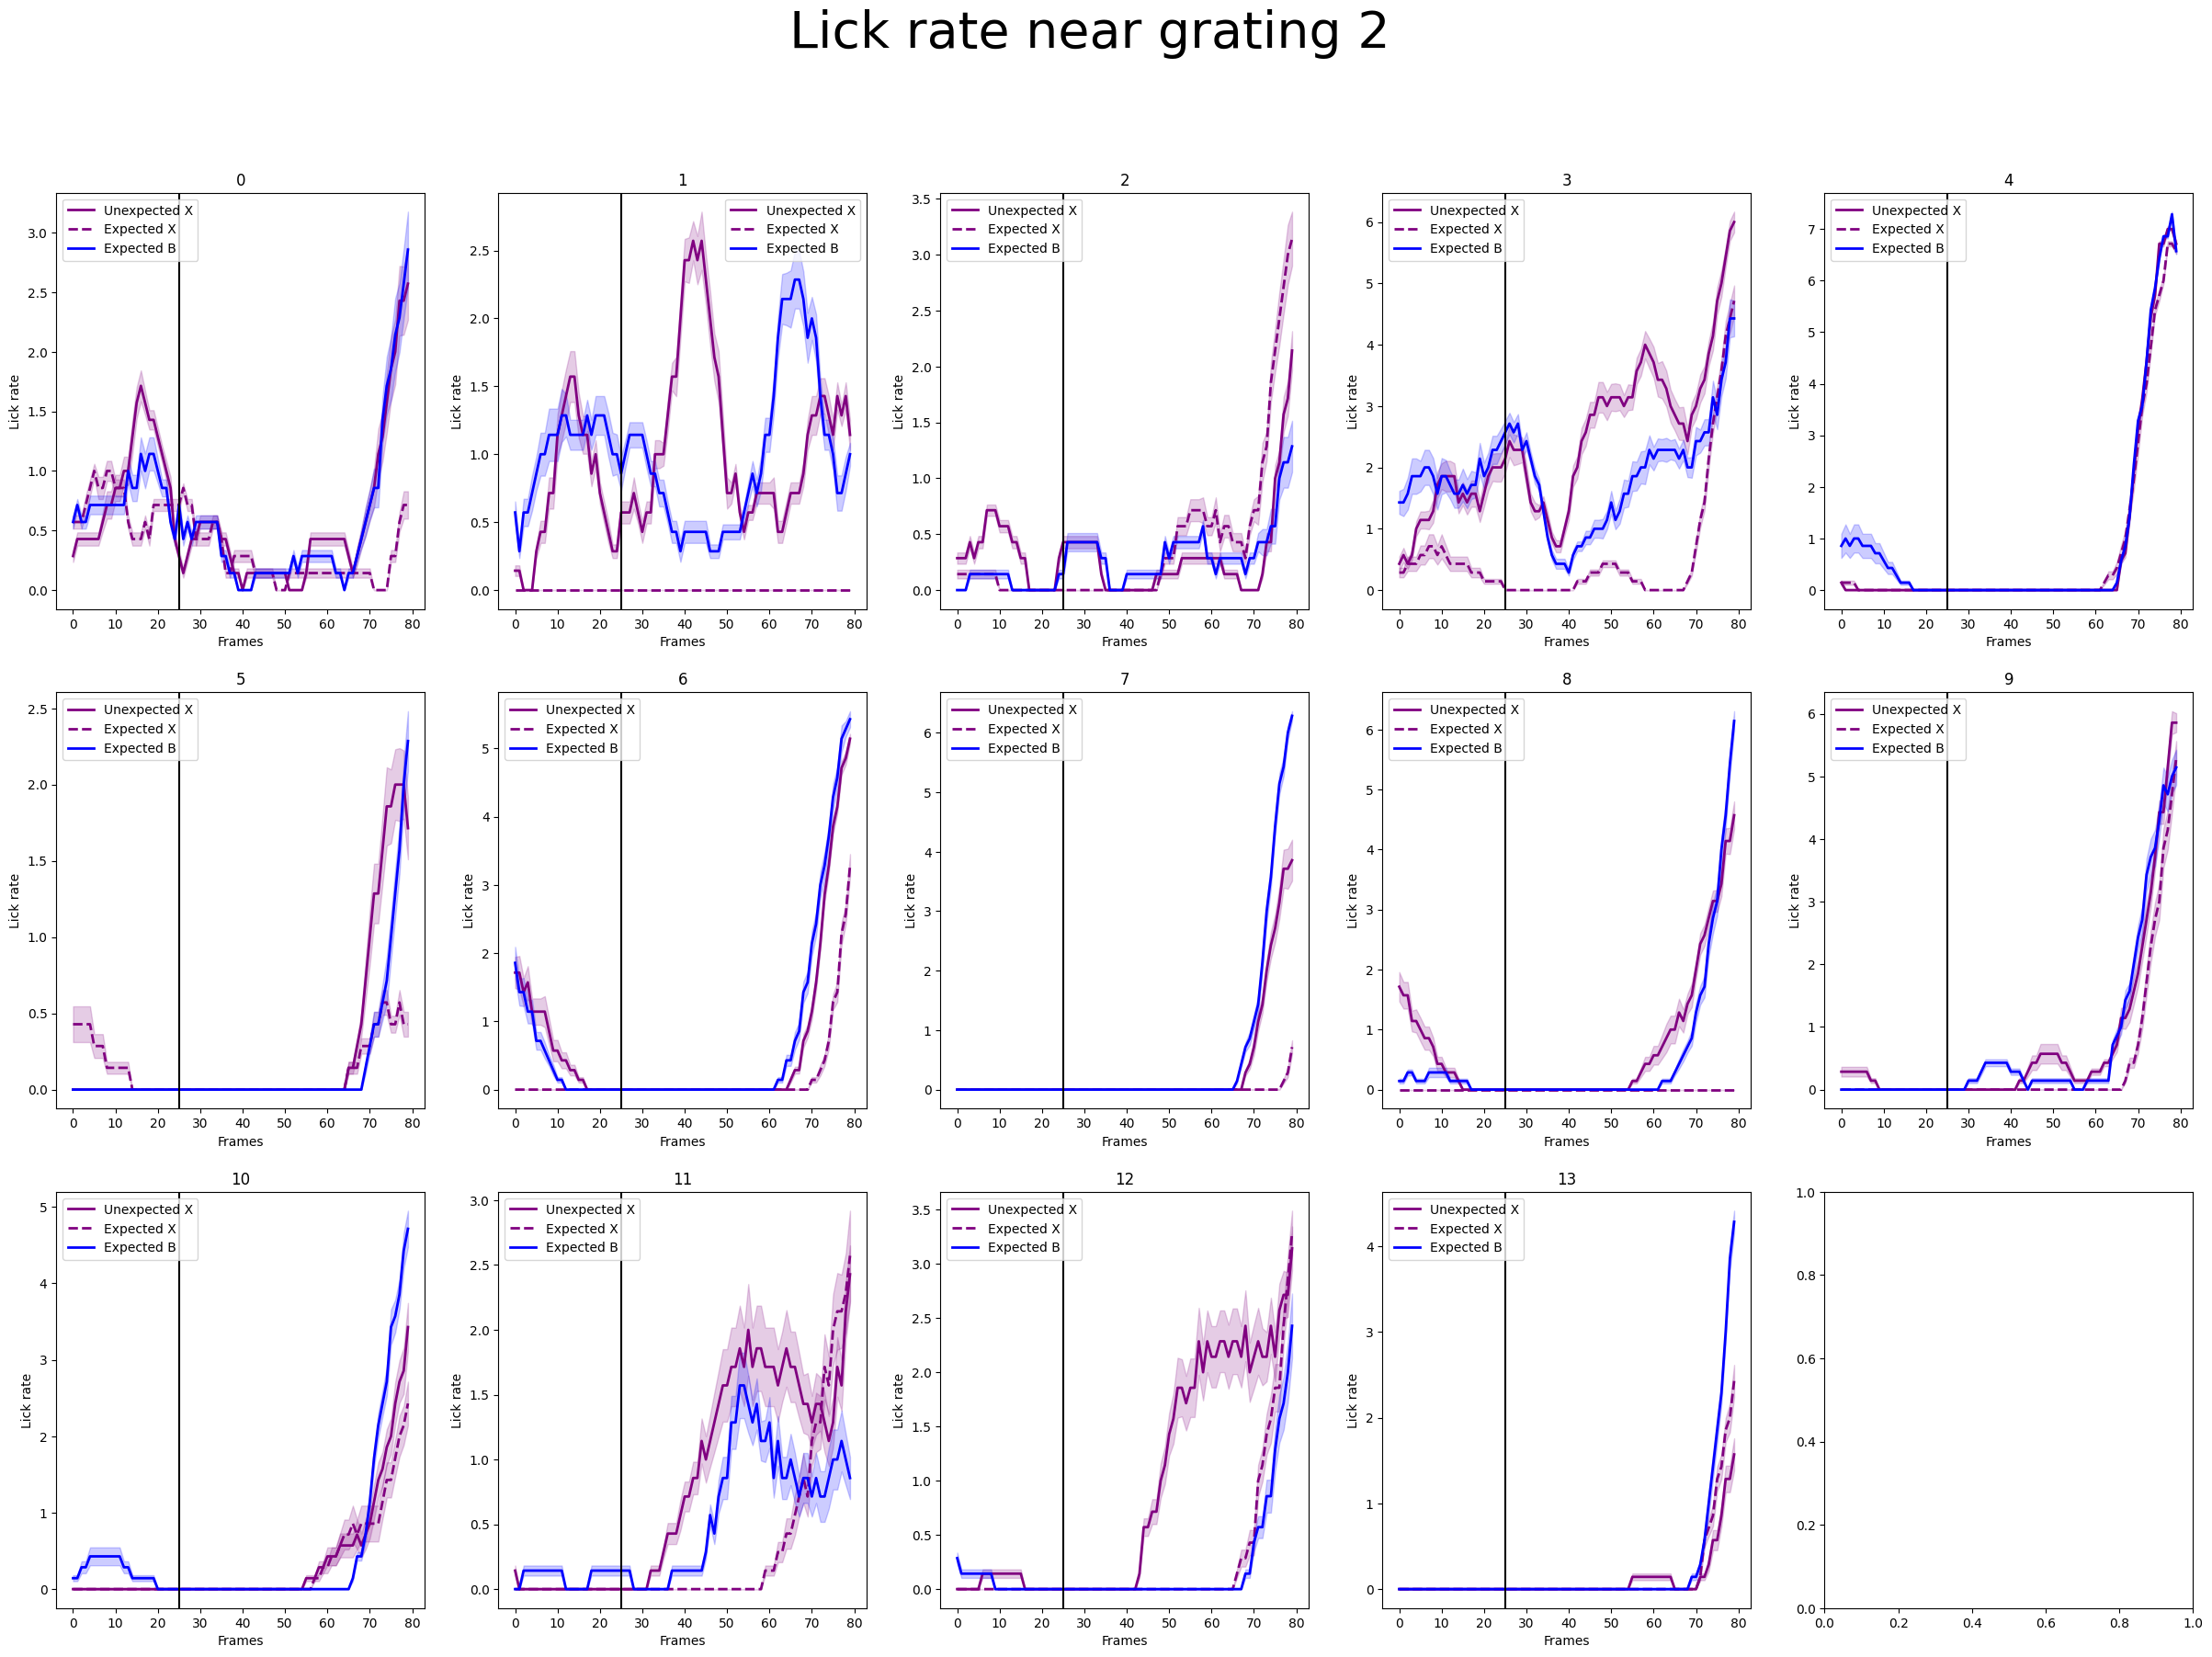

In [96]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20)) 
fig.suptitle("Lick rate near grating 2", fontsize=40)
t_frames = 80
for i, ani in enumerate(behv_data):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][unexp_grat[ani][:7]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][unexp_grat[ani][21:28]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate[ani][exp_grat[ani][:7]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([25], color='black')
    ax.set_ylabel('Lick rate')
    ax.set_xlabel('Frames')
    ax.set_title(f'{ani}')
    ax.legend()

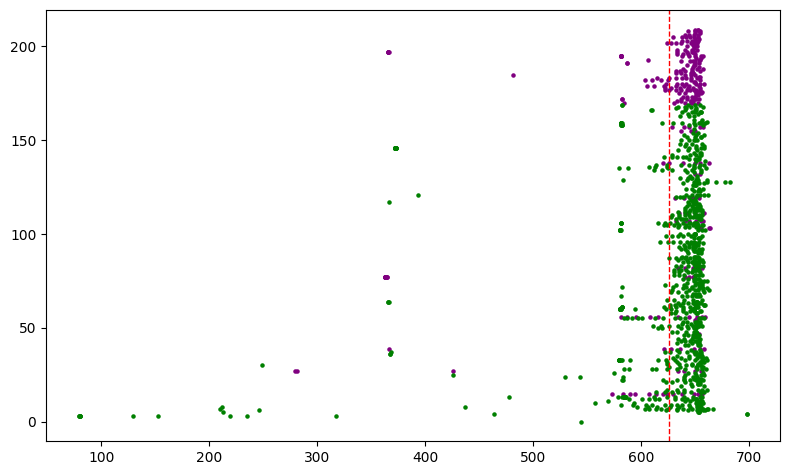

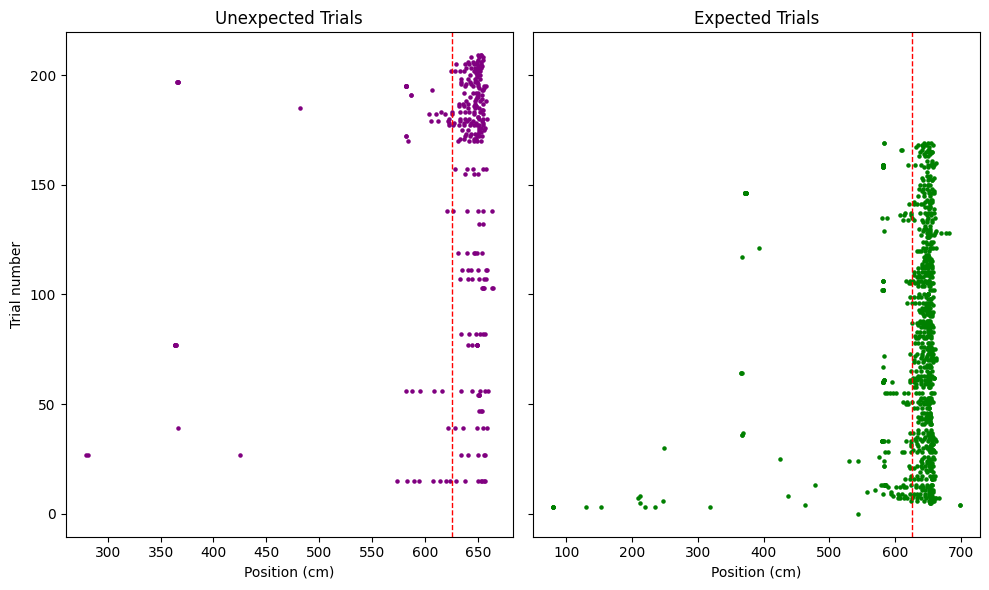

In [ ]:
ani = 11

ani_positions = data[ani]['real_position'] * 700/5
aligned_exp = []
aligned_unexp = []
for i, trial_start in enumerate(data[ani]['trial_start_indices']):
    if i < len(data[ani]['trial_start_indices']) - 1:  
        trial_end = data[ani]['trial_start_indices'][i+1]
    else:
        trial_end = len(data[ani]['real_position'])
    for num, lick in enumerate(lick_record[ani][trial_start:trial_end]):
        if lick == 1 and i in data[ani]['unpred_trials']['gr_2']:
            aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
        if lick ==1 and i in data[ani]['pred_trials']:
            aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
aligned_exp = np.array(aligned_exp)
aligned_unexp = np.array(aligned_unexp)

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
axes.scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
axes.axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
fig.suptitle('')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
# Unexpected trials
axes[0].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
axes[0].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Unexpected Trials')
axes[0].set_xlabel('Position (cm)')
axes[0].set_ylabel('Trial number')
# Expected trials
axes[1].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
axes[1].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Expected Trials')
axes[1].set_xlabel('Position (cm)')
plt.tight_layout()
plt.show()

In [ ]:
# ani = 0
# ani_positions = data[ani]['position'] * 700/5
# aligned_exp = []
# aligned_unexp = []
# for i, trial_start in enumerate(data[ani]['trial_start_indices']):
#     if i < len(data[ani]['trial_start_indices']) - 1:  
#         trial_end = data[ani]['trial_start_indices'][i+1]
#     else:
#         trial_end = len(data[ani]['position']) 
#     for num, lick in enumerate(lick_record[ani][trial_start:trial_end]):
#         if lick == 1 and i in data[ani]['unpred_trials']['gr_2']:
#             aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
#         if lick ==1 and i in data[ani]['pred_trials']:
#             aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
# aligned_exp = np.array(aligned_exp)
# aligned_unexp = np.array(aligned_unexp)

# fig, axes = plt.subplots(figsize=(8,5))
# axes.scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
# axes.scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
# axes.axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
# axes.axvline(x=2.16*700/5, color='red', linestyle='--', linewidth=1)
# axes.axvline(x=3.69*700/5, color='red', linestyle='--', linewidth=1)
# fig.suptitle('')
# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
# # Unexpected trials
# axes[0].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
# axes[0].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
# axes[0].axvline(x=2.16*700/5, color='red', linestyle='--', linewidth=1)
# axes[0].axvline(x=3.69*700/5, color='red', linestyle='--', linewidth=1)
# axes[0].set_title('Unexpected Trials')
# axes[0].set_xlabel('Position (cm)')
# axes[0].set_ylabel('Trial number')
# # Expected trials
# axes[1].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
# axes[1].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
# axes[1].axvline(x=2.16*700/5, color='red', linestyle='--', linewidth=1)
# axes[1].axvline(x=3.69*700/5, color='red', linestyle='--', linewidth=1)
# axes[1].set_title('Expected Trials')
# axes[1].set_xlabel('Position (cm)')
# plt.tight_layout()
# plt.show()

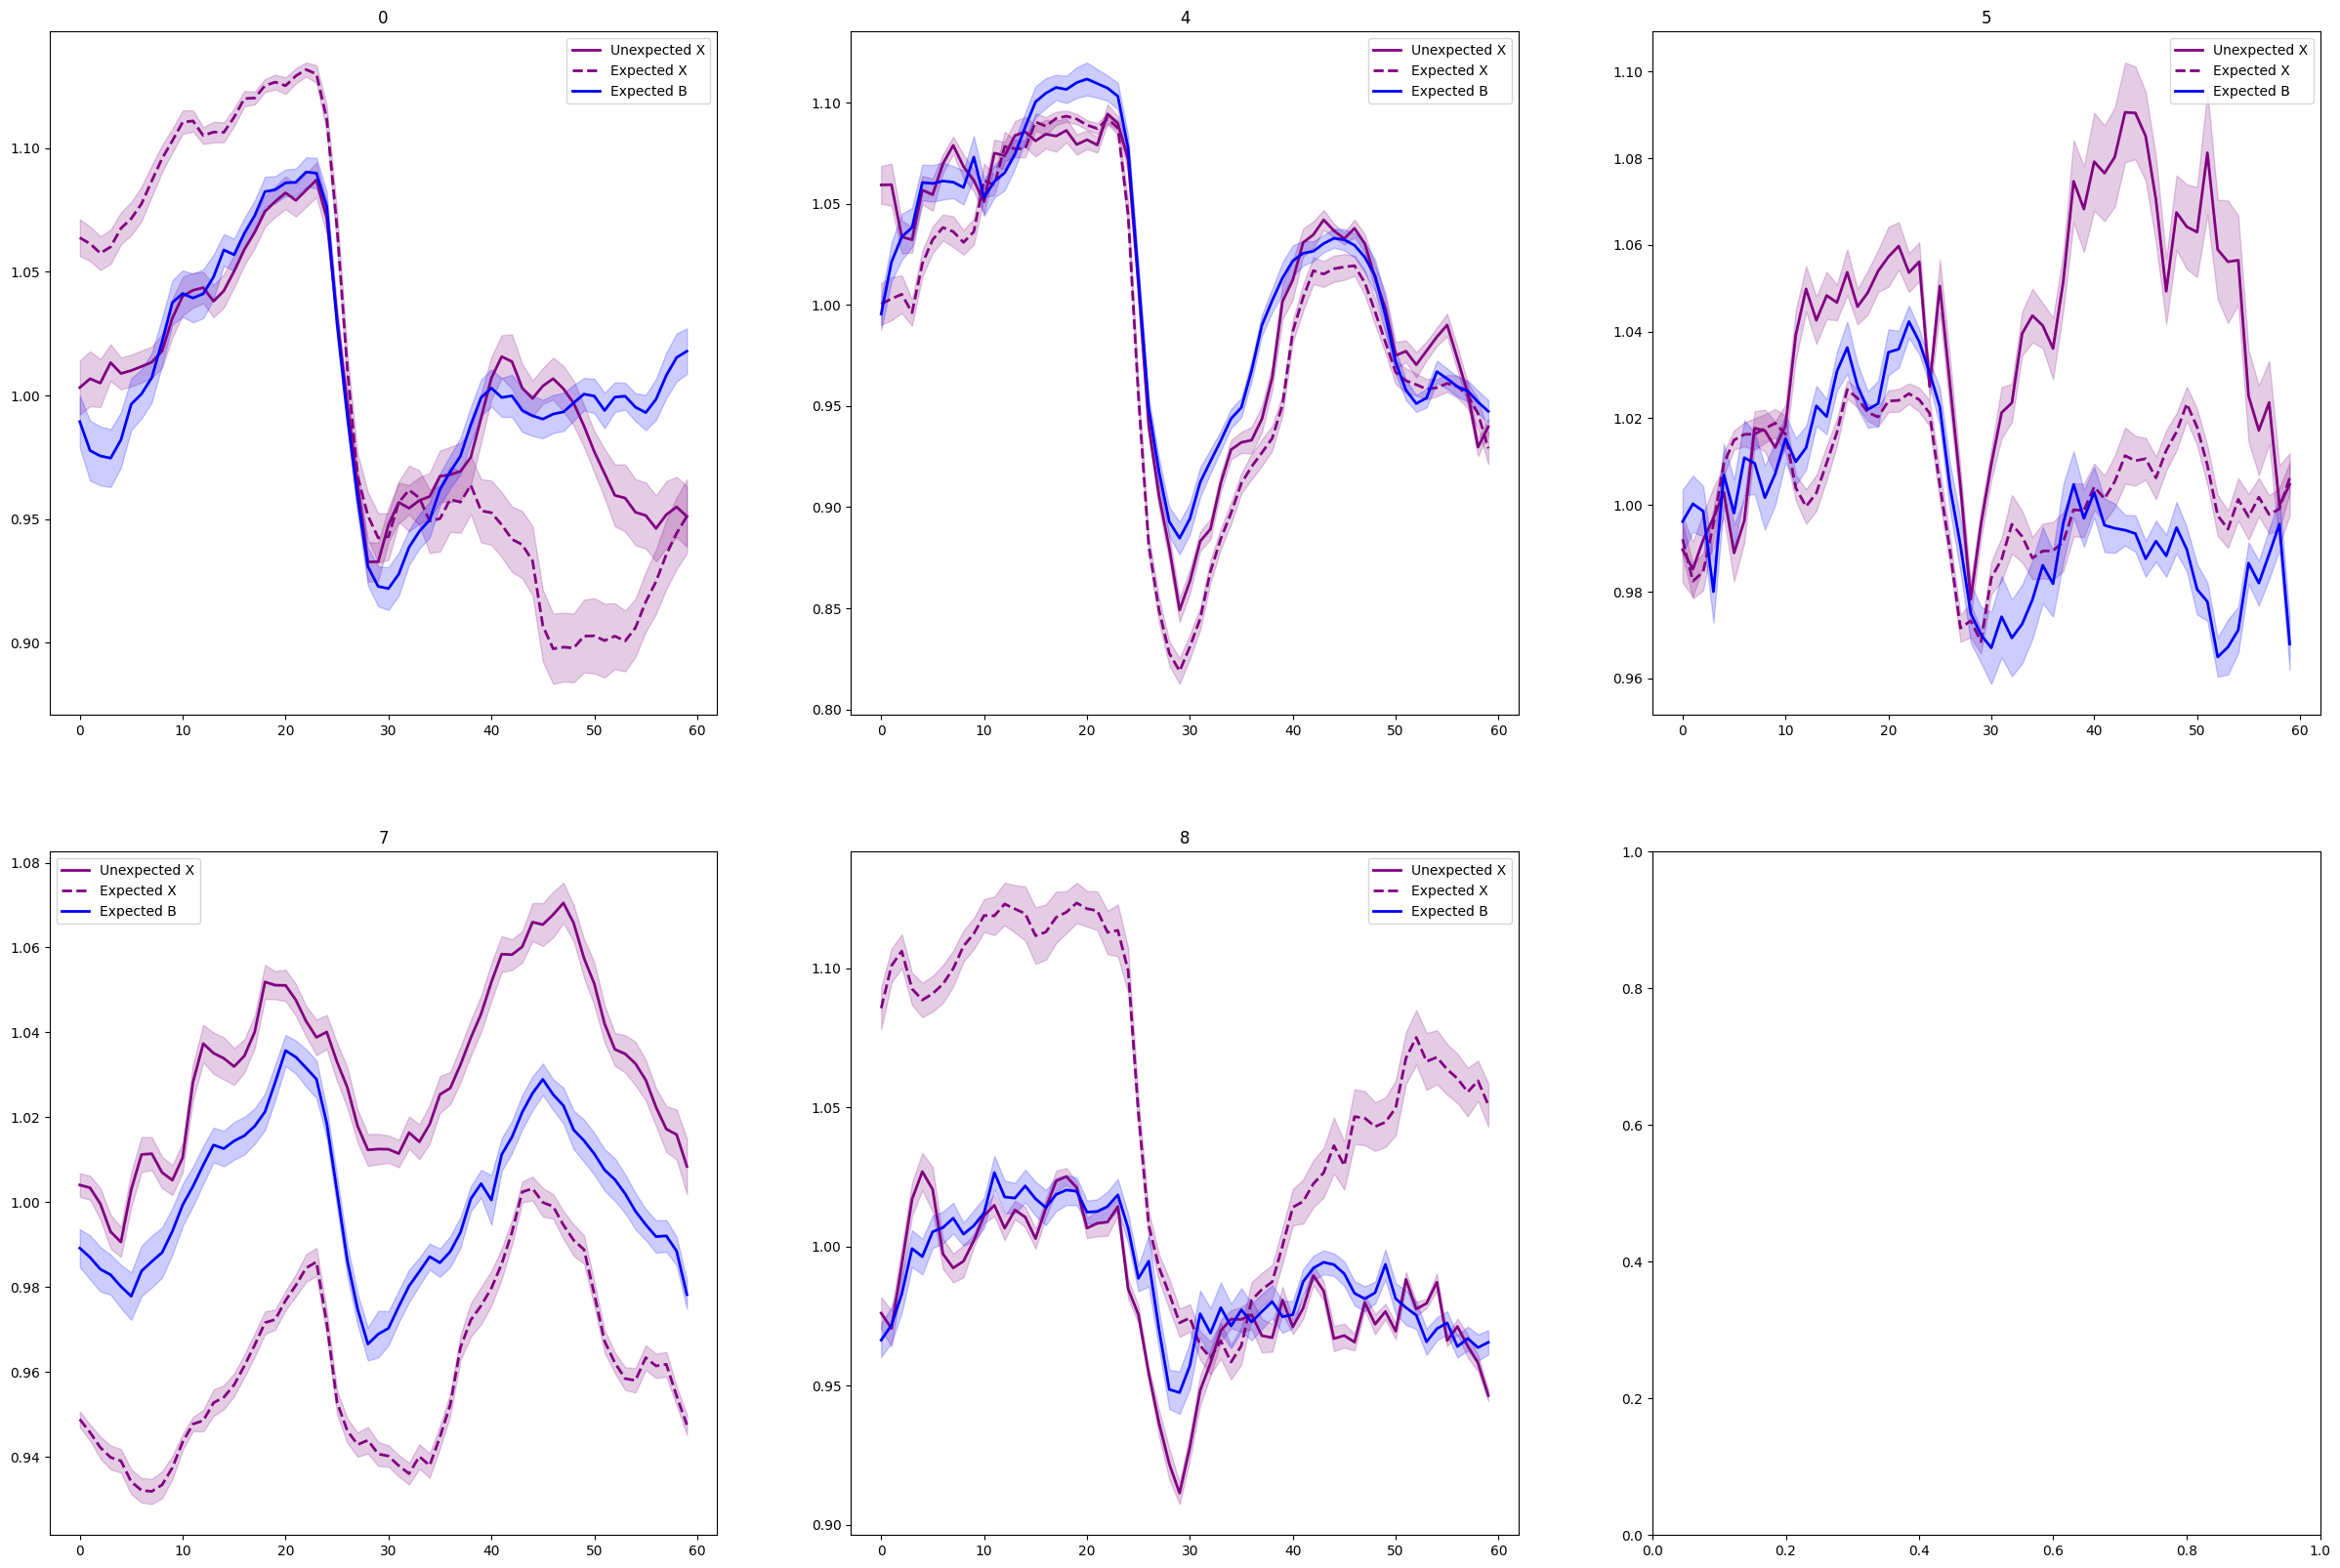

In [50]:
# Pupil Size near grating for each animal normalised

unexp_grat = {}
exp_grat = {}
normalised_pupil = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    normalised_pupil[ani] = data[ani]['pupil']/ np.nanmedian(data[ani]['pupil'])
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data[ani]['grating_indices']['gr_2'][trial])
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data[ani]['grating_indices']['gr_2'][trial-2])

fig, axes = plt.subplots(2, 3, figsize=(30, 20)) 
axes = axes.flatten()
t_frames = 60

for i, ani in enumerate([0,4,5,7,8]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), normalised_pupil[ani][unexp_grat[ani][:7]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), normalised_pupil[ani][unexp_grat[ani][15:28]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), normalised_pupil[ani][exp_grat[ani][:15]], color='blue', alpha=0.2, label= 'Expected B')
    ax.set_title(f'{ani}')
    ax.legend()

# pupil dilate speed after stimuli.. 